In [ ]:
! gdown 1xjGp9KnVPzoV4w2uEQesVPXOd0CJ6Qr4

Downloading...
From: https://drive.google.com/uc?id=1xjGp9KnVPzoV4w2uEQesVPXOd0CJ6Qr4
To: /content/time_series_test.csv
100% 53.1k/53.1k [00:00<00:00, 60.0MB/s]


# Временные ряды

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.api import tsa
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import scipy.stats as st
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("/content/time_series_test.csv")
df["Time"] = df["Time"].apply(lambda x: datetime.strptime(x, "%m/%d/%y %H:%M"))

In [ ]:
df.head(3)

,Time,Users
0,2017-01-01 00:00:00,34002
1,2017-01-01 01:00:00,37947
2,2017-01-01 02:00:00,41517


In [ ]:
def plot_time_series(df, size=(10, 5)):
  plt.figure(figsize=size);
  ax = sns.lineplot(df, x="Time", y="Users");
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%-d\n%B'));
  plt.title("Online users");
  plt.grid(True);

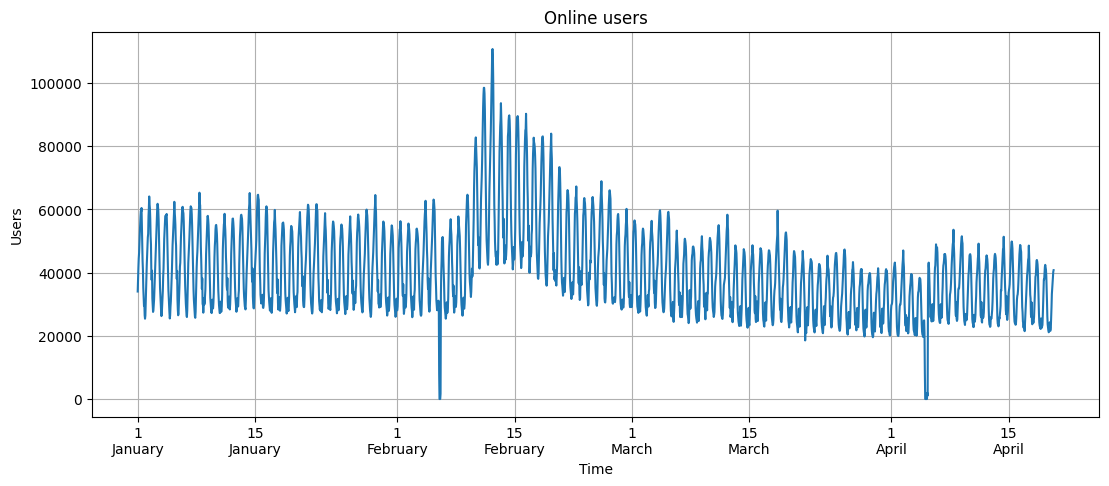

In [ ]:
plot_time_series(df, size=(13, 5))

# Сглаживание с помощью скользящей средней




In [ ]:
new_df = pd.DataFrame({"Time": df["Time"], "Users": df["Users"].rolling(24*7).mean()}) #24*7 - сглаживание по неделям

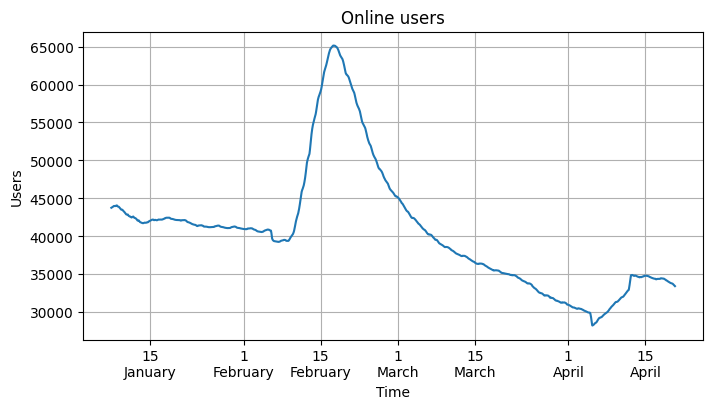

In [ ]:
plot_time_series(new_df, size=(8, 4))

# Экспоненциальное сглаживание
S[t] = a * x[t] + (1-a) * S[t-1]

S[t] - экспоненциальное среднее, x[t] - значения, которые сглаживаются, a - сглаживающий фактор

In [ ]:
def exponential_smoothing(series, alpha):
  res = [series[0]]
  for t in range(1, len(series)):
    res.append( alpha*series[t] + (1-alpha)*res[-1] )
  return res

In [ ]:
new_df = pd.DataFrame({"Time": df["Time"], "Users": exponential_smoothing(df["Users"], 0.05)}) #alpha можно регулировать

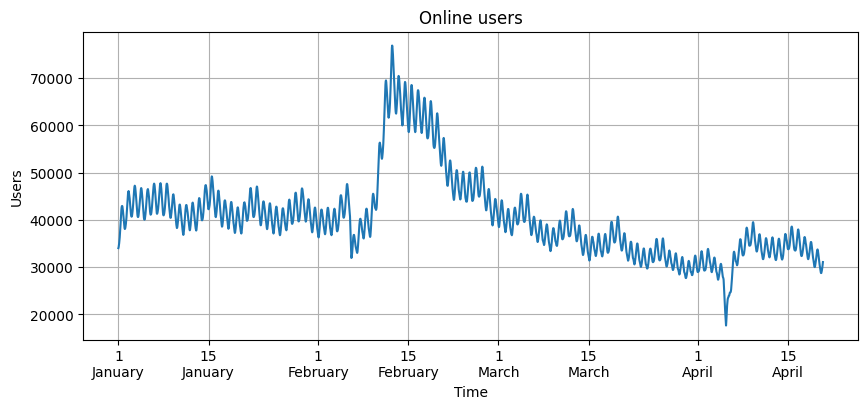

In [ ]:
plot_time_series(new_df, size=(10, 4))

# Двойное экспоненциальное сглаживание

L[x] = a * y[x] + (1-a) * (L[x-1]+B[x-1])

B[x] = b * (L[x]-L[x-1]) + (1-b) * B[x-1]

Y[x+1] = L[x] + B[x]

L - уровень, B - тренд

a, b - задаваемые коэффициенты

Y, y - сглаженное значение и реальное значение


In [ ]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

In [ ]:
time = pd.Series(df["Time"].iloc[-1] + timedelta(hours=1))
new_df = pd.DataFrame({"Time": df["Time"],\
                       "Users": double_exponential_smoothing(df["Users"], 0.05, 0.02)})

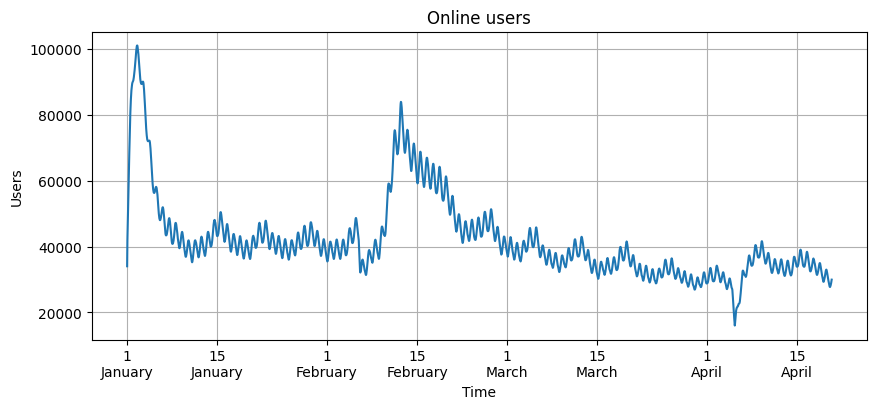

In [ ]:
plot_time_series(new_df, size=(10, 4))

# Тройное экспоненциальное сглаживание

https://en.wikipedia.org/wiki/Exponential_smoothing

In [ ]:
def triple_exponential_smoothing(series, alpha, beta, gamma, period, n_pred=10):
  level = [series[period]]
  trend = [1/period*sum([(series[period+i]-series[i])/period for i in range(period)])]
  n = len(series) // period
  a = [sum(series[period*j+i] for i in range(period))/period for j in range(n)]
  seasonal = [1/n*sum(series[period*j+i]/a[j] for j in range(n)) for i in range(period)]

  result = []
  prediction = []

  for t in range(period, len(series)):
    level.append( alpha*series[t]/seasonal[t-period] + (1-alpha)*(level[-1]+trend[-1]) )
    trend.append( beta*(level[-1]-level[-2]) + (1-beta)*trend[-1] )
    seasonal.append( gamma*series[t]/level[-1] + (1-gamma)*seasonal[t-period] )
    result.append( (level[-1]+trend[-1])*seasonal[t-period+1] )

  for t in range(2, n_pred+2):
    prediction.append( (level[-1]+t*trend[-1])*seasonal[len(seasonal)-period+(t-1)%period] )

  return result, prediction

In [ ]:
def timeseriesCVscore(x):
    errors = []
    values = df["Users"]
    tscv = TimeSeriesSplit(n_splits=3)

    for train, test in tscv.split(values):
        predictions = triple_exponential_smoothing(values[train], *x, period, len(test))[1]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    return np.mean(errors)

period = 168
x = [0.1, 0.1, 0.1]
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 0.99), (0, 0.99), (0, 0.99)))
x=opt.x

In [ ]:
x

array([0.32424243, 0.00259233, 0.        ])

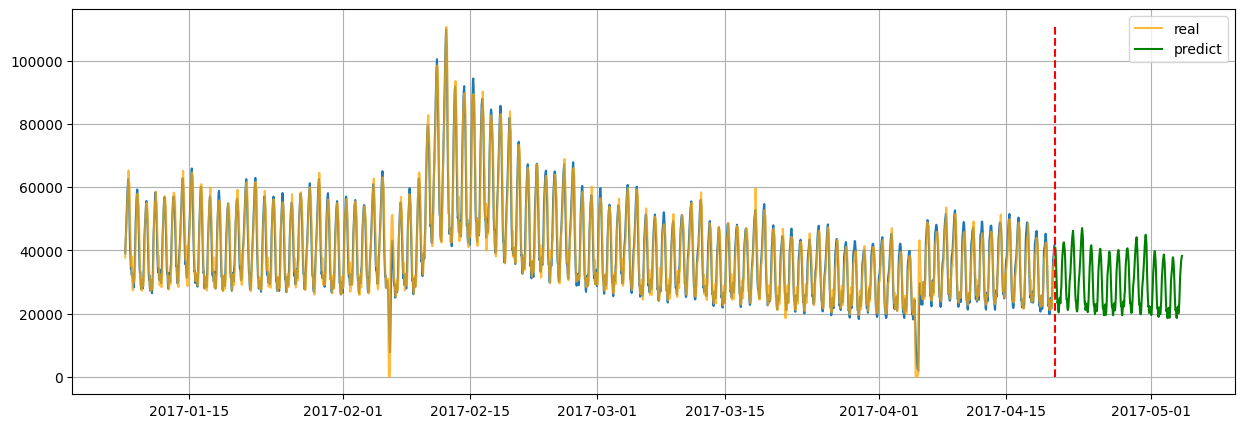

In [ ]:
n_pred = period*2
time = [df["Time"].max()]
for _ in range(n_pred):
  time.append( time[-1] + timedelta(hours=1) )
time = time[1:]

plt.figure(figsize=(15, 5));
y = triple_exponential_smoothing(df["Users"], *x, period, n_pred);
plt.plot(df["Time"].iloc[period:], y[0]);
plt.plot(df["Time"].iloc[period:], df["Users"].iloc[period:], label="real", alpha=0.75, color="orange");
plt.plot(time, y[1], color="green", label="predict");
plt.plot([df["Time"].max()]*2, [df["Users"].min(), df["Users"].max()], color="red", linestyle="--");
plt.legend();
plt.grid(True);

In [ ]:
n_pred = 168
data = pd.Series(df["Users"])
data.index = df["Time"]
model_fit = ExponentialSmoothing(data, seasonal_periods=168, trend="add", seasonal='add').fit(smoothing_level=0.2, smoothing_trend=0.01, smoothing_seasonal=0.3)
pred_data = model_fit.forecast(n_pred)
time = [df["Time"].max()]
for _ in range(n_pred):
  time.append( time[-1] + timedelta(hours=1) )
time = time[1:]
pred_data.index = time

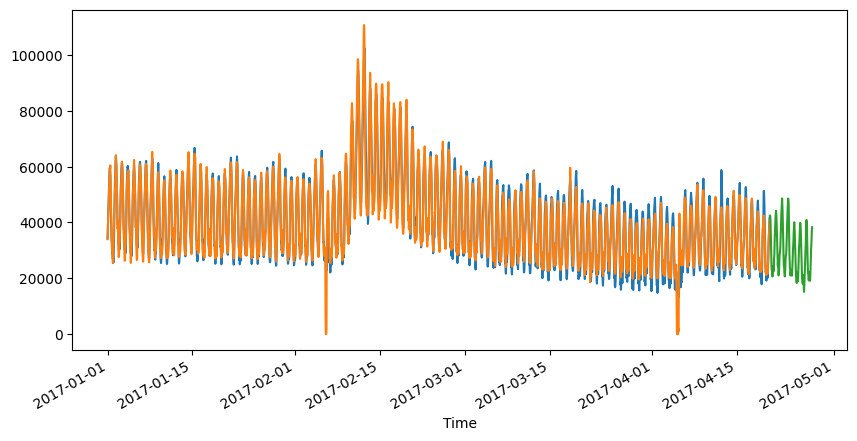

In [ ]:
model_fit.fittedvalues.plot(figsize=(10,5));
data.plot();
pred_data.plot();

# Автокорреляция самописная



In [ ]:
def autocorrelation(series, nlags=10):
  result = [1]
  for i in range(1, nlags+1):
    result.append(np.corrcoef(series[i:], series[:-i])[0, 1])
  return result

In [ ]:
def plot_autocorrelation(series, nlags, size=(12, 4)):
  corr = autocorrelation(series, nlags)
  plt.figure(figsize=size)
  for k in range(nlags+1):
    plt.plot([k, k], [0, corr[k]], color="lightgrey");
  plt.plot([0, nlags], [0, 0], color="black");
  plt.scatter(range(0, nlags+1), corr, linewidths=0.1, color="black", zorder=2);
  plt.grid(True);

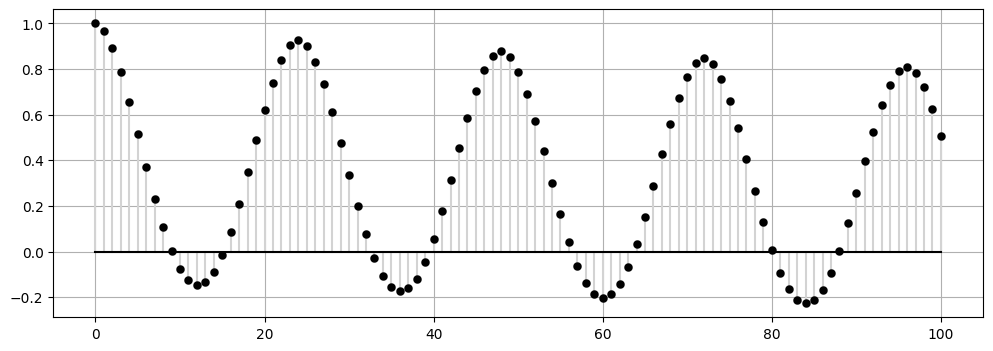

In [ ]:
nlags = 100
plot_autocorrelation(df["Users"], nlags)

# Автокорреляция в statsmodels

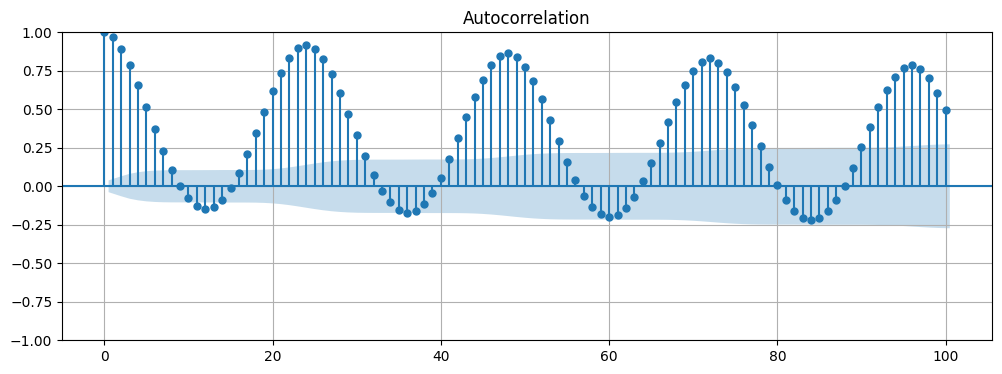

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
plt.grid(True)
tsa.graphics.plot_acf(df["Users"], lags=nlags, ax=ax);

# Стационарность

Стационарность или постоянство — свойство процесса не менять свои характеристики со временем.

Ряд стационарный, если матожидание и дисперсия независимо от рассматриваемого периода времени имеют постоянное значение, а автоковариация зависит только от величины лага между рассматриваемыми переменными.


# Проверка на стационарность

In [ ]:
result = adfuller(df['Users'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('  %s: %.3f' % (key, value))

ADF Statistic: -2.245379
p-value: 0.190189
Critical Values:
  1%: -3.433
  5%: -2.863
  10%: -2.567


# Методы борьбы с нестационарными рядами:

#Стабилизация дисперсии с преобразованием Бокса-Кокса

In [ ]:
def boxcox(series, lmbda=0):
  series = np.array(series)
  if lmbda:
    return (series**lmbda-1) / lmbda
  else:
    return np.log(series)

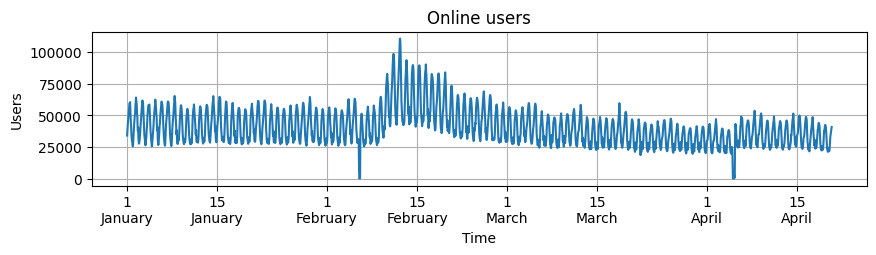

In [ ]:
plot_time_series(df, size=(10, 2))

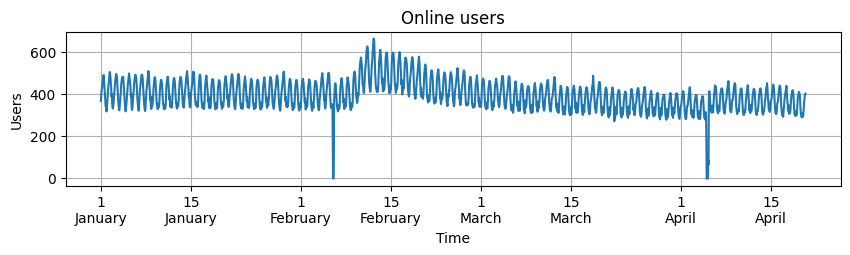

In [ ]:
new_df = pd.DataFrame({"Time": df["Time"], "Users": st.boxcox(df["Users"], 0.5)})
plot_time_series(new_df, size=(10, 2))

In [ ]:
'p-value: %f' % adfuller(new_df['Users'])[1]

'p-value: 0.043351'

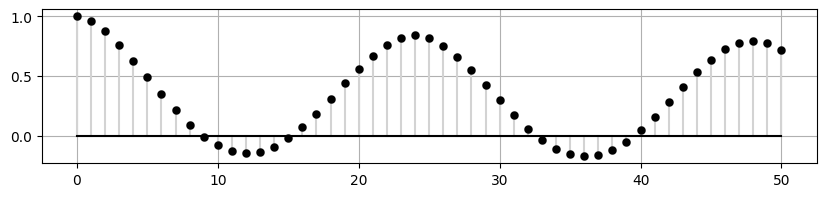

In [ ]:
plot_autocorrelation(new_df["Users"], 50, size=(10, 2))

#Дифференцирование ряда

y'[t] = y[t] - y[t-1]

In [ ]:
periods = 168
diff_series = df["Users"].diff(periods).dropna().reset_index(drop=True) # сезонное дифференцирование

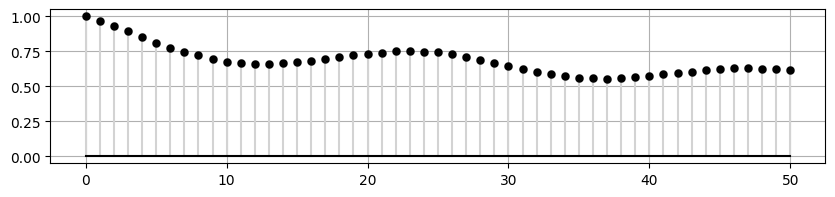

In [ ]:
new_df = pd.DataFrame({"Time": df["Time"].iloc[:-periods-1], "Users": diff_series})
plot_autocorrelation(new_df["Users"], 50, size=(10, 2))

Смотрим на график частной автокорреляции

In [ ]:
def levinson_durbin_pacf(s, nlags=10): # самописная функция частной автокорреляции
    order = nlags
    sxx_m = [np.cov(s, s)[0, 1]] + [np.cov(s[i:], s[:-i])[0, 1] for i in range(1, order+1)]

    phi = np.zeros((order + 1, order + 1), "d")
    sig = np.zeros(order + 1)

    phi[1, 1] = sxx_m[1] / sxx_m[0]
    sig[1] = sxx_m[0] - phi[1, 1] * sxx_m[1]
    for k in range(2, order + 1):
        phi[k, k] = (
            sxx_m[k] - np.dot(phi[1:k, k - 1], sxx_m[1:k][::-1])
        ) / sig[k - 1]

        for j in range(1, k):
            phi[j, k] = phi[j, k - 1] - phi[k, k] * phi[k - j, k - 1]
        sig[k] = sig[k - 1] * (1 - phi[k, k] ** 2)

    pacf_ = np.diag(phi).copy()
    pacf_[0] = 1.0
    return pacf_

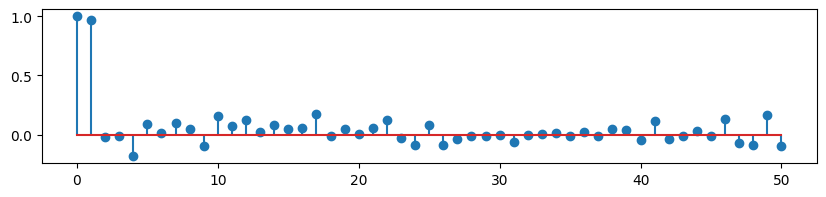

In [ ]:
plt.figure(figsize=(10, 2))
plt.stem(range(51), levinson_durbin_pacf(diff_series, nlags=50));

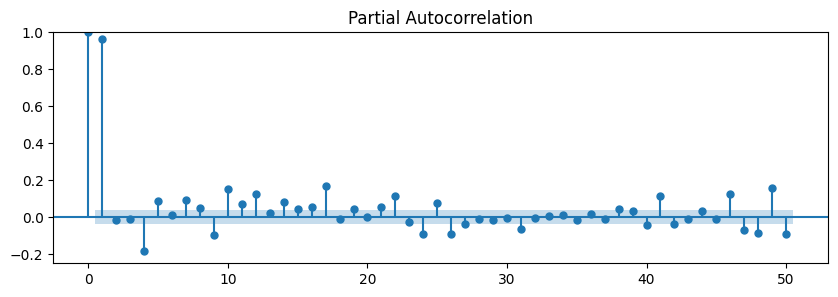

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
tsa.graphics.plot_pacf(diff_series, lags=50, ax=ax);
plt.ylim([-0.25, 1]);

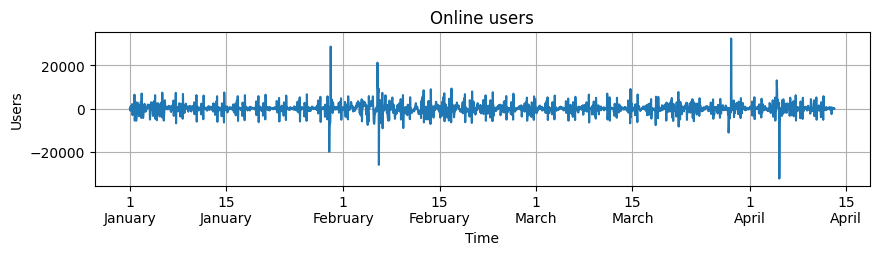

In [ ]:
diff_series = diff_series.diff(1).dropna().reset_index(drop=True) # еще раз дифференцируем с значением 1, так как на графике частной автокорреляции значим только один лаг
new_df = pd.DataFrame({"Time": df["Time"].iloc[:-periods-1], "Users": diff_series})
plot_time_series(new_df, size=(10, 2))

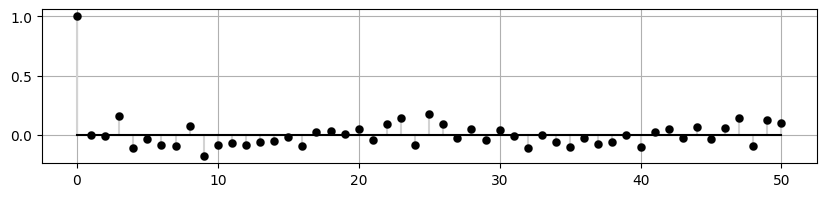

In [ ]:
plot_autocorrelation(new_df["Users"], 50, size=(10, 2))

In [ ]:
'p-value: %f' % adfuller(new_df['Users'])[1] # p-value = 0 => ряд стационарный

'p-value: 0.000000'

# ARIMA

SARIMA - (p, d, q) x (P, D, Q, s)

s - длина сезонного периода.

d, D - дифференцирование и сезонное дифференцирование. Порядки дифференцирования подбираются так, чтобы ряд стал стационарным.

q, Q - порядки модели MA (Q отвечает за сезонность). Начальное приближение для q - номер последнего несезонного лага, при котором автокорреляция значима, для Q - номер последнего сезонного лага, при котором автокорреляция значима. Условие, которое должно выполняться: Если Q > 0, то q < s, иначе модель не обучится.

p, P - порядки модели AR (P отвечает за сезонность). Начальное приближение для p - номер последнего несезонного лага, при котором частичная автокорреляция значима, для P - номер последнего сезонного лага, при котором частичная автокорреляция значима. Условие, которое должно выполняться: Если P > 0, то p < s, иначе модель не обучится.

Далее можно перебирать разные значения в окрестностях этих гиперпараметров, сравнивать модели по AIC, выбрать лучшую модель и посмотреть на остатки лучшей модели, чтобы понять, всю ли полезную информацию модель вычленила из данных.

In [2]:
!gdown 11U1_3kTgm-B00X4uqEbIqPnsr9btdZcv

Downloading...
From: https://drive.google.com/uc?id=11U1_3kTgm-B00X4uqEbIqPnsr9btdZcv
To: /content/passengers.csv
100% 1.75k/1.75k [00:00<00:00, 7.72MB/s]


In [3]:
passengers = pd.read_csv("/content/passengers.csv", parse_dates=["Month"])
passengers["Passengers"] = passengers["#Passengers"]
passengers = passengers.drop("#Passengers", axis=1)

In [4]:
passengers.head(3)

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132


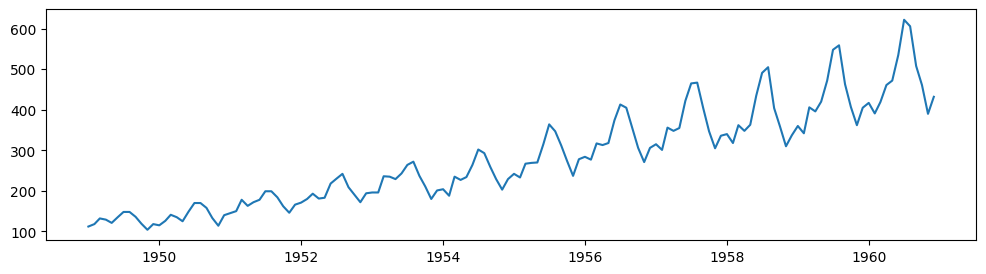

In [5]:
plt.figure(figsize=(12, 3))
plt.plot(passengers["Month"], passengers["Passengers"]);

# Начальное приближение гиперпараметров ARIMA

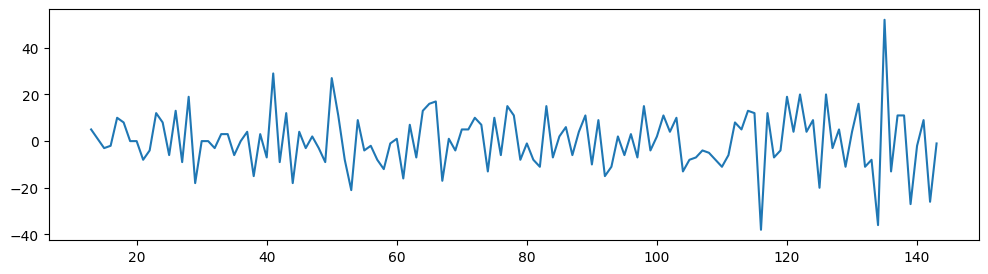

In [6]:
plt.figure(figsize=(12, 3))
plt.plot(passengers["Passengers"].diff(12).diff(1).dropna());

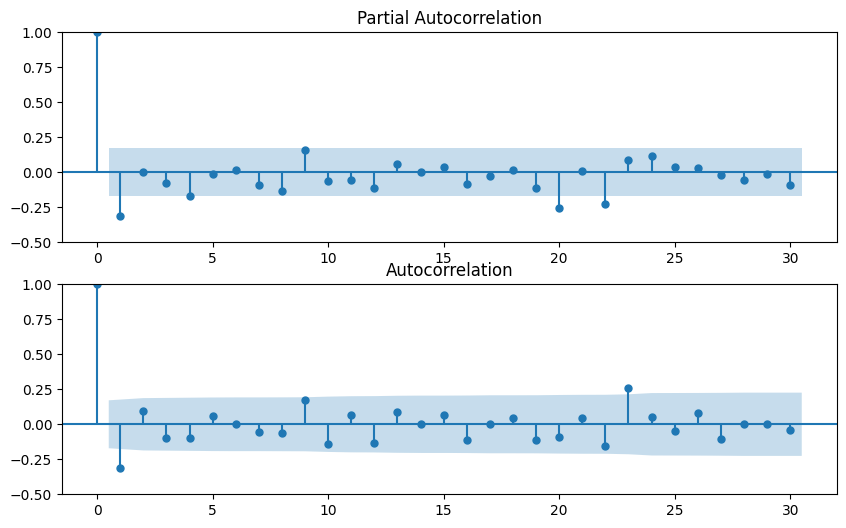

In [7]:
data = passengers["Passengers"].diff(12).diff(1).dropna()
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
tsa.graphics.plot_pacf(data, lags=30, ax=ax[0]);
ax[0].set_ylim([-0.5, 1]);
tsa.graphics.plot_acf(data, lags=30, ax=ax[1]);
ax[1].set_ylim([-0.5, 1]);

d = 1
D = 1
p = 22
P = 0
q = 23
Q = 0

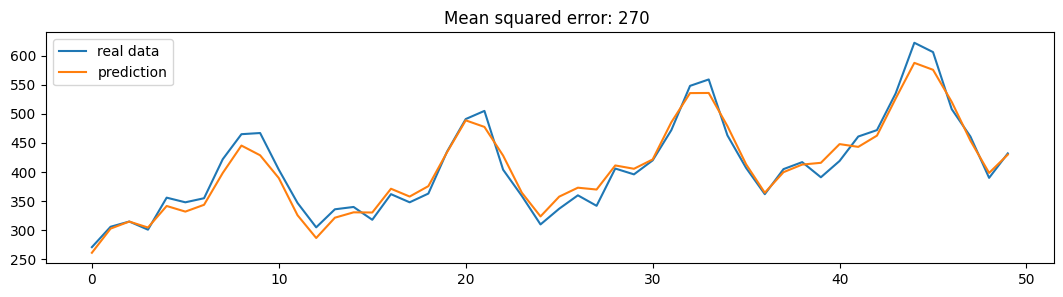

In [8]:
d = 50
train = passengers["Passengers"][:-d]
test = passengers["Passengers"][-d:]
arima = ARIMA(train, order = (22, 1, 23), seasonal_order = (0, 1, 0, 12))
arima_fit = arima.fit();
predict = arima_fit.predict(start=len(train), end=len(train)+d-1)
plt.figure(figsize=(13, 3))
plt.plot(range(len(test)), test, label="real data");
plt.plot(range(len(predict)), predict, label="prediction");
plt.title("Mean squared error: {} ".format(round(mean_squared_error(test, predict))))
plt.legend();

# Перебор гиперпараметров SARIMA с помощью кросс-валидации

In [ ]:
def arima_cv(data):
    order = [(i, j, k) for i in range(4) for j in range(2) for k in range(4)]
    seasonal_order = [(i, j, k, 12) for i in range(3) for j in range(2) for k in range(3)]

    tscv = TimeSeriesSplit(n_splits=5)

    mse = np.inf
    best_param = order[0]
    best_param2 = seasonal_order[0]

    for order_ in tqdm(order):
      for seasonal_order_ in seasonal_order:
        new_mse = 0
        for train, test in tscv.split(data):
          try: #на некоторых параметрах модель не обучается
            model = ARIMA(data.iloc[train], order=order_, seasonal_order=seasonal_order_)
            model_fit = model.fit()
          except:
            print(f"ERROR - {order_} x {seasonal_order_}")
          pred_y = model_fit.predict(len(train), len(train)+len(test)-1)
          new_mse += mean_squared_error(data.iloc[test], pred_y)
        if new_mse < mse:
          mse = new_mse
          best_param = order_
          best_param2 = seasonal_order_
          print(f"best MSE = {mse}, best parameter = {best_param} x {best_param2}")
    return mse, best_param, best_param2

In [ ]:
arima_cv(passengers["Passengers"])

  0%|          | 0/32 [00:00<?, ?it/s]

best MSE = 104608.65916613114, best parameter = (0, 0, 0) x (0, 0, 0, 12)
best MSE = 80479.3173631444, best parameter = (0, 0, 0) x (0, 0, 1, 12)
best MSE = 55723.9802880568, best parameter = (0, 0, 0) x (0, 0, 2, 12)
best MSE = 17124.208333333332, best parameter = (0, 0, 0) x (0, 1, 0, 12)
best MSE = 15337.351474430445, best parameter = (0, 0, 0) x (0, 1, 1, 12)
best MSE = 13124.557472363551, best parameter = (0, 0, 0) x (0, 1, 2, 12)
best MSE = 9295.61725072921, best parameter = (0, 0, 0) x (1, 1, 0, 12)
best MSE = 3987.0441100353964, best parameter = (0, 0, 0) x (1, 1, 1, 12)
best MSE = 3874.6516922184646, best parameter = (0, 0, 0) x (2, 1, 2, 12)
ERROR - (1, 1, 1) x (2, 0, 2, 12)
ERROR - (2, 0, 0) x (2, 0, 1, 12)
ERROR - (2, 0, 3) x (2, 0, 1, 12)
ERROR - (2, 1, 0) x (1, 0, 0, 12)
ERROR - (2, 1, 2) x (2, 0, 0, 12)
ERROR - (2, 1, 2) x (2, 0, 1, 12)
ERROR - (2, 1, 2) x (2, 0, 1, 12)
ERROR - (2, 1, 3) x (1, 0, 2, 12)
ERROR - (2, 1, 3) x (2, 0, 2, 12)
ERROR - (3, 1, 1) x (1, 0, 0, 12)


(3874.6516922184646, (0, 0, 0), (2, 1, 2, 12))

# Обучаем модель на подобранных гиперпараметрах

In [15]:
d = 50
train = passengers["Passengers"][:-d]
test = passengers["Passengers"][-d:]
arima = ARIMA(train, order = (0, 0, 0), seasonal_order = (2, 1, 2, 12))
arima_fit = arima.fit();

# Прогнозы подобранной модели

In [16]:
predict = arima_fit.predict(start=len(train), end=len(train)+d-1)

In [17]:
predict.head(3)

,predicted_mean
94,256.229736
95,298.392518
96,308.958532


Модель неплохо предсказала данные, которые до этого не видела

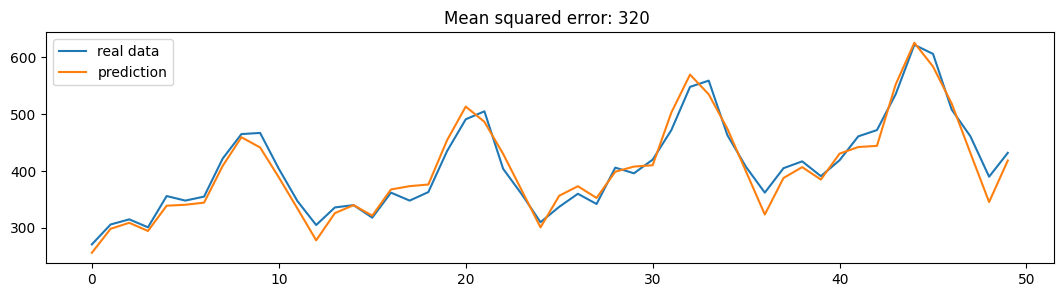

In [18]:
plt.figure(figsize=(13, 3))
plt.plot(range(len(test)), test, label="real data");
plt.plot(range(len(predict)), predict, label="prediction");
plt.title("Mean squared error: {} ".format(round(mean_squared_error(test, predict))))
plt.legend();

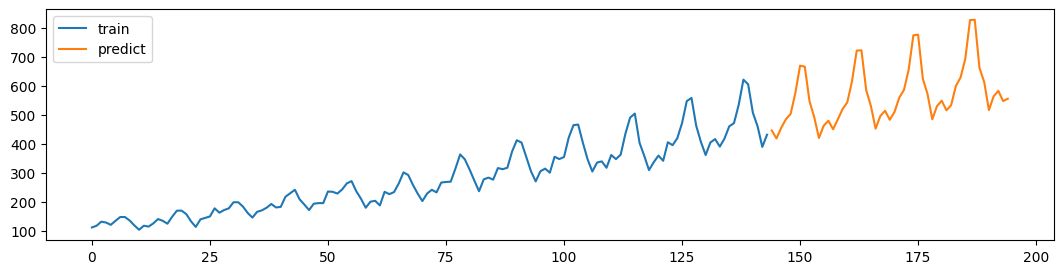

In [19]:
d = 50
train = passengers["Passengers"]
arima = ARIMA(train, order = (0, 0, 0), seasonal_order = (2, 1, 2, 12))
arima_fit = arima.fit();
predict = arima_fit.predict(start=len(train), end=len(train)+d)
plt.figure(figsize=(13, 3))
plt.plot(range(len(train)), train, label="train");
plt.plot(range(len(train), len(train)+d+1), predict, label="predict")
plt.legend();

# Прогнозирование с помощью обычной линейной регрессии

In [22]:
def get_data(data, lag_start=5, lag_end=20, test_size=0.3):
    data = pd.DataFrame(data.copy())
    data.columns = ["Date", "y"]

    test_index = int(len(data)*(1-test_size))

    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

    data["Month"] = data.index.month
    data['month_average'] = list(map(dict(data[:test_index].groupby('Month')["y"].mean()).get, data.Month))

    data = data.drop(["Month", "Date"], axis=1)
    data = data.dropna()
    data = data.reset_index(drop=True)

    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]

    return X_train, X_test, y_train, y_test

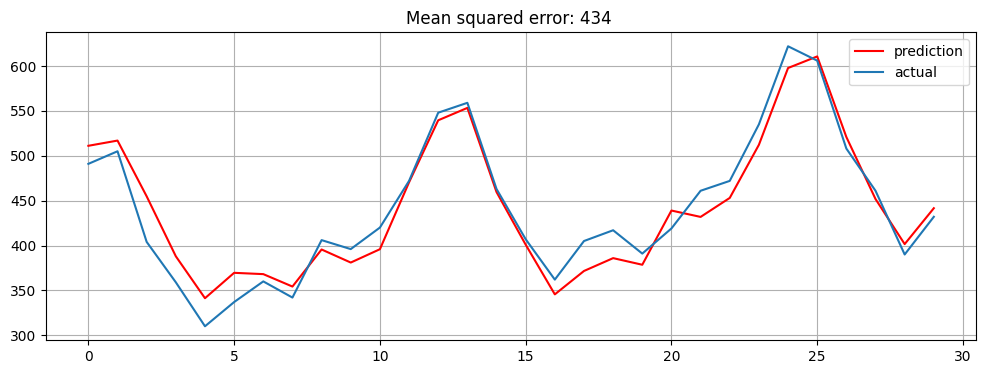

In [23]:
ps = passengers.copy()
ps.index = list(ps.Month)

X_train, X_test, y_train, y_test = get_data(ps, lag_start=10, lag_end=15)

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(12, 4))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Mean squared error: {} ".format(round(mean_squared_error(prediction, y_test))))
plt.grid(True);